In [75]:
import numpy as np
import pandas as pd
import root_pandas as rp
import uproot as ur
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import ROOT
import new_analysis
import array
import matplotlib
matplotlib.rcParams['text.usetex'] = False

In [76]:
a = new_analysis.analysis()

/home/jeef/workspace/jeff_workspace/analysis/phase3/new_analysis.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  means[col]=0 #will be deleted at the end. Used so we can append rows of means
/home/jeef/workspace/jeff_workspace/analysis/phase3/new_analysis.py:271: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errs[col] = 0
/home/jeef/workspace/jeff_workspace/analysis/phase3/new_analysis.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [77]:
LER_cont_inj = a.get_tpc_data_during_study_period("LER", "Cont_inj")
LER_decay = a.get_tpc_data_during_study_period("LER", "Decay")
HER_cont_inj = a.get_tpc_data_during_study_period("HER", "Cont_inj")
HER_decay = a.get_tpc_data_during_study_period("HER", "Decay")
Lumi_cont_inj = a.get_tpc_data_during_study_period("Lumi", "Cont_inj")
Lumi_decay = a.get_tpc_data_during_study_period("Lumi", "Decay")
Lumi = {}
HER = {}
LER = {}
Single_beam = {}
for tpc in Lumi_decay.keys():
    Lumi[tpc] = Lumi_decay[tpc].append(Lumi_cont_inj[tpc])
    HER[tpc] = HER_decay[tpc].append(HER_cont_inj[tpc])
    LER[tpc] = LER_decay[tpc].append(LER_cont_inj[tpc])
    Single_beam[tpc] = LER[tpc].append(HER[tpc])
    
    #Lumi[tpc] = Lumi_cont_inj[tpc]
    #HER[tpc] = HER_cont_inj[tpc]
    #LER[tpc] = LER_cont_inj[tpc]
    #Single_beam[tpc] = LER[tpc].append(HER[tpc])
    
    Lumi[tpc].index = [i for i in range(0,len(Lumi[tpc]))]
    Single_beam[tpc].index = [i for i in range(0,len(Single_beam[tpc]))]
MC = a.apply_energy_calibrations_to_MC()

/home/jeef/anaconda3/envs/my_root_env/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


elepaio 86


### Apply "xray veto" cuts for MC

In [78]:
for tpc in MC.keys():
    MC[tpc] = MC[tpc].loc[MC[tpc]['reco_energy']>8]
    MC[tpc].index = [i for i in range(0,len(MC[tpc]))]

# Fold phi for angular analysis

In [82]:
for tpc in ['elepaio', 'tako', 'palila', 'iiwi', 'nene', 'humu']:
    Lumi[tpc]['phi_fold'] = Lumi[tpc]['phi'].apply(lambda x: x if x <= 90 else 180-x)
    Lumi[tpc]['phi_fold'] = Lumi[tpc]['phi_fold'].apply(lambda x: x if x >= -90 else -180-x)
    HER[tpc]['phi_fold'] = HER[tpc]['phi'].apply(lambda x: x if x <= 90 else 180-x)
    HER[tpc]['phi_fold'] = HER[tpc]['phi_fold'].apply(lambda x: x if x >= -90 else -180-x)
    LER[tpc]['phi_fold'] = LER[tpc]['phi'].apply(lambda x: x if x <= 90 else 180-x)
    LER[tpc]['phi_fold'] = LER[tpc]['phi_fold'].apply(lambda x: x if x >= -90 else -180-x)
    Single_beam[tpc]['phi_fold'] = Single_beam[tpc]['phi'].apply(lambda x: x if x <= 90 else 180-x)
    Single_beam[tpc]['phi_fold'] = Single_beam[tpc]['phi_fold'].apply(lambda x: x if x >= -90 else -180-x)
    MC[tpc]['phi_fold'] = (MC[tpc]['fit_phi']*180/np.pi).apply(lambda x: x if x <= 90 else 180-x)
    MC[tpc]['phi_fold'] = MC[tpc]['phi_fold'].apply(lambda x: x if x >= -90 else -180-x)

KstestResult(statistic=0.20567020637146866, pvalue=0.050479181933835604)
KstestResult(statistic=0.12537265329143502, pvalue=0.085860894643071)
KstestResult(statistic=0.16518259129564783, pvalue=0.2731722590096698)
KstestResult(statistic=0.05752881163801247, pvalue=0.4988512804329377)
KstestResult(statistic=0.1214466264825977, pvalue=0.0881443169000804)
KstestResult(statistic=0.1733793752943023, pvalue=0.012925099929441353)


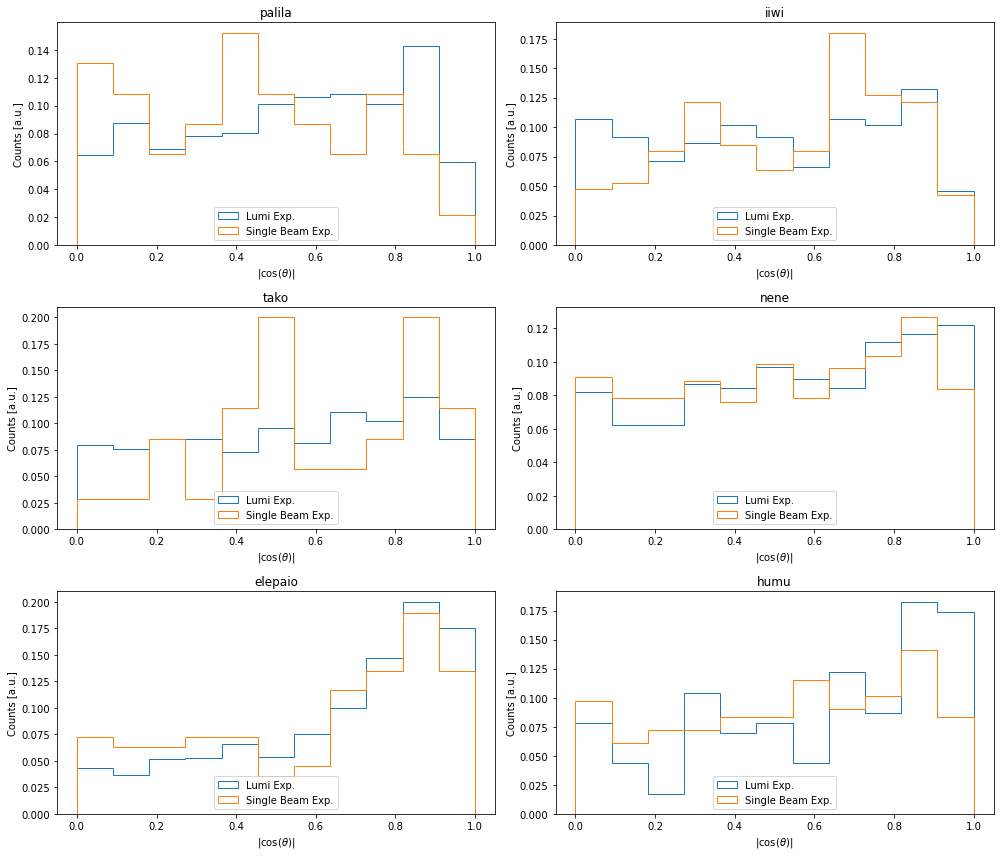

In [102]:
from scipy.stats import ks_2samp
from scipy.stats import epps_singleton_2samp
from scipy.stats import mannwhitneyu
plt.figure(figsize = (14,12))
i = 1
for tpc in ['palila', 'iiwi', 'tako', 'nene', 'elepaio', 'humu']:
    tmp_lumi = Lumi[tpc].loc[(Lumi[tpc]['track_energy']>150) & (np.abs(Lumi[tpc]['phi_fold']<27))]
    tmp_single = Single_beam[tpc].loc[(Single_beam[tpc]['track_energy']>150) & (np.abs(Lumi[tpc]['phi_fold']<27))]
    plt.subplot(3,2,i)
    
    (counts_lumi, bins_lumi) = np.histogram(np.abs(np.cos(tmp_lumi['theta']*np.pi/180)), bins=11, range = (0,1))
    factor_lumi = 1/len(tmp_lumi)
    plt.hist(bins_lumi[:-1], bins_lumi, weights=factor_lumi*counts_lumi, label = 'Lumi Exp.', histtype = 'step')
    
    (counts, bins) = np.histogram(np.abs(np.cos(tmp_single['theta']*np.pi/180)), bins=11, range = (0,1))
    factor = 1/len(tmp_single)
    plt.hist(bins[:-1], bins, weights=factor*counts, label = 'Single Beam Exp.', histtype = 'step')
    
    #plt.hist(np.abs(np.cos(tmp_lumi['theta']*np.pi/180)), bins = 11, range = (0,1), histtype = 'step', label = 'lumi')#, norm = matplotlib.colors.LogNorm(vmin=0.9, vmax=100))
    #plt.hist(np.abs(np.cos(tmp_single['theta']*np.pi/180)), bins = 11, range = (0,1), histtype = 'step', label = 'single')
    #plt.hist(tmp['phi_fold'], bins = 21, range = (-90,90))
    
    plt.legend(loc = 'lower center')
    plt.xlabel(r'|cos($\theta$)|')
    plt.title(tpc)
    #plt.ylim(0,1.25)
    plt.ylabel('Counts [a.u.]')
    i+=1
    
    result = ks_2samp(np.abs(np.cos(tmp_lumi['theta']*np.pi/180)), np.abs(np.cos(tmp_single['theta']*np.pi/180)))
    print(result)
    
plt.tight_layout()
plt.show()

In [70]:
MC_Lumi = {}
#for tpc in ['palila', 'tako', 'elepaio']:
for tpc in ['palila', 'tako', 'elepaio', 'nene', 'iiwi', 'humu']:
    MC_Lumi[tpc] = MC[tpc].loc[(MC[tpc]['bgType'] == 'RBB_Lumi') | (MC[tpc]['bgType'] == 'twoPhoton_Lumi')]
    #MC_Lumi[tpc] = MC_Lumi[tpc].loc[((MC_Lumi[tpc]['truth_mother_Z']>-870) & #Line is for RBB hotspot
    #           (MC_Lumi[tpc]['truth_mother_Z']<-750) & (MC_Lumi[tpc]['truth_mother_X']>20) &
    #                                   (MC_Lumi[tpc]['truth_mother_X']<60) &
    #                                   (np.abs(MC_Lumi[tpc]['truth_mother_Y'])<20))
    #                                  |                                
    #                                  (MC_Lumi[tpc]['truth_mother_Z']>1390) &
    #                                  (MC_Lumi[tpc]['truth_mother_Z']<1680) &
    #                                  (MC_Lumi[tpc]['truth_mother_X']<80) &
    #                                  (MC_Lumi[tpc]['truth_mother_X']>30) &
    #                                  (np.abs(MC_Lumi[tpc]['truth_mother_Y'])<20)] #FWD and BWD hotspots

KstestResult(statistic=0.3356286454957874, pvalue=0.0001810313769324834)
KstestResult(statistic=0.3813216453135536, pvalue=0.2744230711345579)
KstestResult(statistic=0.32772870999832515, pvalue=1.4264972325282743e-27)
KstestResult(statistic=0.27006265954977954, pvalue=1.3322676295501878e-15)
KstestResult(statistic=0.5965856861457649, pvalue=0.000637266530323588)
KstestResult(statistic=0.3985867954625582, pvalue=0.0)


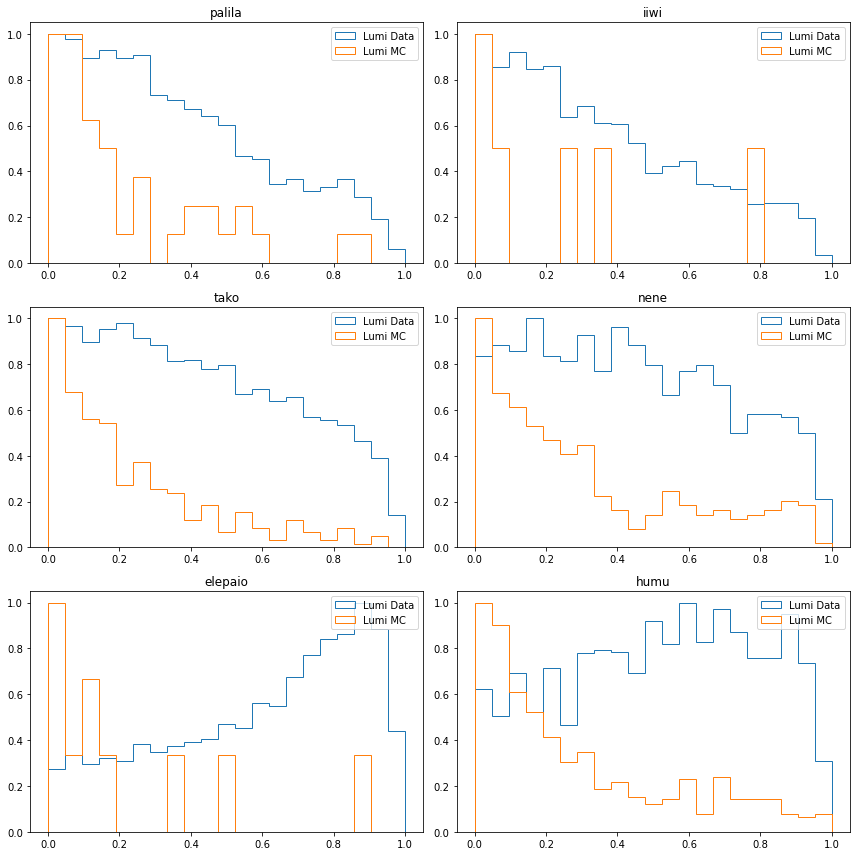

In [103]:
i=1
plt.figure(figsize = (12,12))
for tpc in ['palila', 'iiwi', 'tako', 'nene', 'elepaio', 'humu']:
    
    tmp_lumi = Lumi[tpc].loc[(Lumi[tpc]['track_energy']>0)]
    tmp_MC = MC_Lumi[tpc].loc[MC_Lumi[tpc]['reco_energy']>0]#MC_Lumi[tpc].loc[MC_Lumi[tpc]['reco_energy']>20]
    
    plt.subplot(3,2,i)
    
    (counts_lumi, bins_lumi) = np.histogram(np.abs(np.cos(tmp_lumi['theta']*np.pi/180)), bins=21, range = (0,1))
    factor_lumi = 1/counts_lumi.max()
    plt.hist(bins_lumi[:-1], bins_lumi, weights=factor_lumi*counts_lumi, label = 'Lumi Data', histtype = 'step')
    
    (counts_MC, bins_MC) = np.histogram(np.abs(np.cos(tmp_MC['fit_theta'])), bins=21, range = (0,1))
    factor_MC = 1/counts_MC.max()
    plt.hist(bins_MC[:-1], bins_MC, weights=factor_MC*counts_MC, label = 'Lumi MC', histtype = 'step')
    
    plt.title(tpc)
    plt.legend()
    i+=1
    
    result = ks_2samp(np.abs(np.cos(tmp_lumi['theta']*np.pi/180)), np.abs(np.cos(tmp_MC['fit_theta'])))
    print(result)
plt.tight_layout()
plt.show()

In [63]:
from scipy.stats import ks_2samp
from scipy.stats import epps_singleton_2samp
MC_single = {}
i = 1
plt.figure(figsize = (14,12))
labels = ['z=-5.5m', 'z=+6.5m', 'z=-8.0m', 'z=14m', 'z=-14m', 'z=+16m']
#for tpc in ['palila', 'tako', 'elepaio']:
for tpc in ['palila', 'iiwi', 'tako', 'nene', 'elepaio', 'humu']:
    lumi_data = Lumi_cont_inj[tpc].loc[Lumi_cont_inj[tpc]['track_energy']>100]# & (Lumi_cont_inj[tpc]['phi_fold']>-3)]
    #lumi_data = lumi_data.loc[(lumi_data['phi_fold']<20) & (lumi_data['phi_fold']>-20)]
    single_beam_data = Single_beam_combined[tpc].loc[(Single_beam_combined[tpc]['track_energy']>100)]# & (Lumi_cont_inj[tpc]['phi_fold']>-3)]
    #single_beam_data = single_beam_data.loc[(single_beam_data['phi_fold']<20) & (single_beam_data['phi_fold']>-20)]
    plt.subplot(3,2,i)
    
    (counts_lumi, bins_lumi) = np.histogram(np.abs(np.cos(lumi_data['theta']*np.pi/180)), bins=51, range = (0,1))
    factor_lumi = 1/counts_lumi.max()
    plt.hist(bins_lumi[:-1], bins_lumi, weights=factor_lumi*counts_lumi, label = 'Lumi Data', histtype = 'step')
    
    (counts_sb, bins_sb) = np.histogram(np.abs(np.cos(single_beam_data['theta']*np.pi/180)), bins=51, range = (0,1))
    factor_sb = 1/counts_sb.max()
    plt.hist(bins_sb[:-1], bins_sb, weights=factor_sb*counts_sb, label = 'Single Beam Data', histtype = 'step')
                                                      
    #result = epps_singleton_2samp(np.cos(lumi_data['theta']*np.pi/180), np.cos(single_beam_data['theta']*np.pi/180))
    #print(result)
    
    plt.legend()
    plt.title(labels[i-1])
    plt.ylim(0,1.5)
    i+=1
plt.tight_layout()
plt.show()

NameError: name 'Single_beam_combined' is not defined

<Figure size 1008x864 with 0 Axes>

KstestResult(statistic=0.09387755102040816, pvalue=0.7058614048515456)
KstestResult(statistic=0.2565746753246753, pvalue=0.12090548713505989)
KstestResult(statistic=0.4167702476077735, pvalue=4.429187017152003e-10)


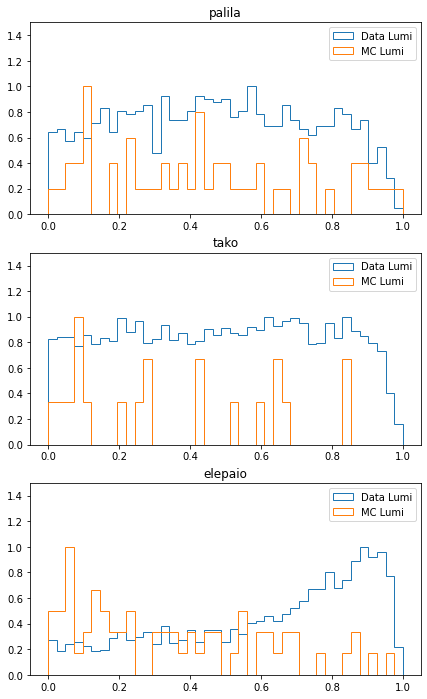

In [22]:
from scipy.stats import ks_2samp
from scipy.stats import epps_singleton_2samp
from scipy.stats import anderson_ksamp
MC_single = {}
i = 1
plt.figure(figsize = (7,12))
for tpc in ['palila', 'tako', 'elepaio']:
#for tpc in ['iiwi', 'nene', 'humu']:
    tmp = MC_Lumi[tpc].loc[MC_Lumi[tpc]['reco_energy']>50]
    MC_single[tpc] = MC[tpc].loc[(MC[tpc]['bgType'] != 'RBB_Lumi') & (MC[tpc]['bgType'] != 'twoPhoton_Lumi')]
    tmp2 = MC_single[tpc].loc[MC_single[tpc]['reco_energy']>50]
    #tmp_data = Single_beam_combined[tpc].loc[(Single_beam_combined[tpc]['phi_fold']<100)]# & (Single_beam_combined[tpc]['phi_fold']>-10)]# & (Lumi_cont_inj[tpc]['phi_fold']>-3)]
    tmp_data = Lumi_cont_inj[tpc].loc[(Lumi_cont_inj[tpc]['phi_fold']<50)]# & (Lumi_cont_inj[tpc]['phi_fold']>-10)]
    tmp_data = tmp_data.loc[tmp_data['track_energy']>50]
    #tmp = tmp.loc[tmp['phi_fold']<-50]
    plt.subplot(3,1,i)
    #plt.hist(np.abs(np.cos(tmp['fit_theta'])), bins = 21, range = (0,1), histtype='step', label = 'Lumi_MC')
    (counts, bins) = np.histogram(np.abs(np.cos(tmp_data['theta']*np.pi/180)), bins=41, range = (0,1))
    factor = 1/counts.max()
    plt.hist(bins[:-1], bins, weights=factor*counts, label = 'Data Lumi', histtype = 'step')
    #plt.hist(np.abs(np.cos(tmp_data['theta']*np.pi/180)), bins = 21, range = (0,1), label = 'data', histtype = 'step')
    (counts_MC, bins_MC) = np.histogram(np.abs(np.cos(tmp2['fit_theta'])), bins=41, range = (0,1))
    factor_MC = 1/counts_MC.max()
    plt.hist(bins_MC[:-1], bins_MC, weights=factor_MC*counts_MC, label = 'MC Lumi', histtype = 'step')
    #plt.hist(np.abs(np.cos(tmp2['fit_theta'])), bins = 21, range = (0,1), histtype = 'step', label = 'Single beam MC')
    #plt.hist(tmp['phi_fold'], bins = 21, range = (-180,180))
    #print(len(tmp))
    #result = ks_2samp(np.abs(np.cos(tmp['fit_theta'])), np.abs(np.cos(tmp2['fit_theta'])))
    #print(result)
    result2 = ks_2samp(np.abs(np.cos(tmp2['fit_theta'])), np.abs(np.cos(tmp_data['theta']*np.pi/180)))
    #result = anderson_ksamp([np.cos(tmp['fit_theta']).to_numpy(), np.cos(tmp_data['theta']*np.pi/180).to_numpy()])
    print(result2)
    plt.legend()
    plt.title(tpc)
    plt.ylim(0,1.5)
    i+=1

In [ ]:
from scipy.stats import ks_2samp
from scipy.stats import epps_singleton_2samp

MC_single = {}
plt.figure(figsize = (7,12))
i = 1
for tpc in ['palila', 'tako', 'elepaio']:
    MC_single[tpc] = MC[tpc].loc[(MC[tpc]['bgType'] != 'RBB_Lumi') & (MC[tpc]['bgType'] != 'twoPhoton_Lumi')]
    tmp2 = MC_single[tpc].loc[MC_single[tpc]['reco_energy']>100]
    plt.subplot(3,1,i)
    plt.hist(np.abs(np.cos(tmp2['fit_theta'])), bins = 21, range = (0,1))
    result = ks_2samp(np.abs(np.cos(tmp['fit_theta'])), np.abs(np.cos(tmp2['fit_theta'])))
    #result = epps_singleton_2samp(np.abs(np.cos(tmp['fit_theta'])), np.abs(np.cos(tmp2['fit_theta'])))
    print(len(tmp2))
    print(result)
    #plt.hist(tmp2['phi_fold'], bins = 21)
    plt.title(tpc)
    i+=1

In [ ]:
MC_Lumi['palila'].columns

In [ ]:
import matplotlib
def plot_theta_phi(side = 'BWD'):
    #tpcs = ['palila', 'iiwi', 'tako', 'nene', 'elepaio', 'humu']
    if side == 'BWD':
        tpcs = ['palila', 'tako', 'elepaio']
    else:
        tpcs = ['humu', 'nene', 'iiwi']
    i = 1
    fig = plt.figure(figsize=(14,12))
    plt.rc('legend', fontsize=12)
    plt.rc('xtick', labelsize=16)
    plt.rc('ytick', labelsize=16)
    plt.rc('axes', labelsize=18)
    plt.rc('axes', titlesize=18)
    for tpc in tpcs:
        #plt.subplot(6,3,i)
        #plt.hist2d(np.cos(LER_cont_inj[tpc]['theta']*np.pi/180), LER_cont_inj[tpc]['phi'], bins = (20,15), range = ((-1.2,1.2), (-185,185)), label = 'LER_cont_inj', norm = matplotlib.colors.LogNorm(vmin=0.9, vmax=100))
        #plt.title(tpc+' LER_cont_inj')
        #plt.xlabel(r'cos($\theta$)')
        #plt.ylabel(r'$\phi$ [$^\circ$]')
        #plt.ylim(-200,200)
        plt.subplot(3,2,i+1)
        plt.hist2d(np.abs(np.cos(Lumi_cont_inj[tpc]['theta']*np.pi/180)), Lumi_cont_inj[tpc]['phi_fold'], bins = (11,9), range = ((0,1), (-90,90)), label = 'Data', vmin = 0)#, norm = matplotlib.colors.LogNorm(vmin=0.9, vmax=100))
        #plt.hist2d(np.cos(Single_beam_combined[tpc]['theta']*np.pi/180), Single_beam_combined[tpc]['phi_fold'], bins = (20,10), range = ((-1.1,1.1), (-95,95)), label = 'Data')#, norm = matplotlib.colors.LogNorm(vmin=0.9, vmax=100))
        plt.title('Luminosity Study')
        plt.xlabel(r'|cos($\theta$)|')
        plt.ylabel(r'$\phi$ [$^\circ$]')
        plt.ylim(-90,90)
        plt.colorbar().set_label('Recoils/bin', rotation = 270, labelpad = 20)
        plt.subplot(3,2,i)
        plt.hist2d(np.abs(np.cos(Single_beam_combined[tpc]['theta']*np.pi/180)), Single_beam_combined[tpc]['phi_fold'], bins = (11,9), range = ((0,1), (-90,90)), label = 'Data', vmin = 0 )#, norm = matplotlib.colors.LogNorm(vmin=0.9, vmax=100))
        plt.title('Single Beam Combined')
        plt.xlabel(r'|cos($\theta$)|')
        plt.ylabel(r'$\phi$ [$^\circ$]')
        plt.ylim(-90,90)
        plt.colorbar().set_label('Recoils/bin', rotation = 270, labelpad = 20)
        #plt.hist2d(MC[tpc]['fit_theta']*180/np.pi, MC[tpc]['fit_phi']*180/np.pi, bins = (10,10), range = ((-180,180), (-185,185)), label = 'MC')#, norm = matplotlib.colors.LogNorm(vmin=0.9, vmax=100))
        #plt.title(tpc+' MC')
        #plt.colorbar()
        #plt.yscale("Log")
        #plt.xlabel(r'cos($\theta$)')
        #plt.ylabel(r'$\phi$ [$^\circ$]')
        #plt.ylim(-200,200)
        #plt.ylim(0.9,3000)
        #plt.legend()
        
        #plt.hist(LER_decay[tpc]['theta'], bins = 90, histtype = 'step', range = (-5,185), label = 'LER_decay', linewidth = 2)
        #plt.hist(HER_decay[tpc]['theta'], bins = 90, histtype = 'step', range = (-5,185), label = 'HER_decay', linewidth = 2)
        #plt.hist(Lumi_decay[tpc]['theta'], bins = 90, histtype = 'step', range = (-5,185), label = 'Lumi_decay', linewidth = 2)
        #plt.title(tpc)
        #plt.yscale("Log")
        #plt.xlabel('Track theta [degrees]')
        #plt.ylim(0.9,3000)
        #plt.legend()
        i+=2
    plt.tight_layout()
    plt.show()
plot_theta_phi('BWD')

In [ ]:
import matplotlib
def plot_theta_phi_MC(side = 'BWD'):
    #tpcs = ['palila', 'iiwi', 'tako', 'nene', 'elepaio', 'humu']
    if side == 'BWD':
        tpcs = ['palila', 'tako', 'elepaio']
    else:
        tpcs = ['humu', 'nene', 'iiwi']
    i = 1
    fig = plt.figure(figsize=(14,12))
    plt.rc('legend', fontsize=12)
    plt.rc('xtick', labelsize=16)
    plt.rc('ytick', labelsize=16)
    plt.rc('axes', labelsize=18)
    plt.rc('axes', titlesize=18)
    for tpc in tpcs:

        plt.subplot(3,2,i+1)
        plt.hist2d(np.abs(np.cos(MC[tpc].loc[(MC[tpc]['bgType'] == 'RBB_Lumi') | (MC[tpc]['bgType'] == 'twoPhoton_Lumi')]['fit_theta'])), MC[tpc].loc[(MC[tpc]['bgType'] == 'RBB_Lumi') | (MC[tpc]['bgType'] == 'twoPhoton_Lumi')]['phi_fold'], bins = (11,9), range = ((0,1), (-90,90)), label = 'Data')#, norm = matplotlib.colors.LogNorm(vmin=0.9, vmax=100))
        #plt.hist2d(np.cos(Single_beam_combined[tpc]['theta']*np.pi/180), Single_beam_combined[tpc]['phi_fold'], bins = (20,10), range = ((-1.1,1.1), (-95,95)), label = 'Data')#, norm = matplotlib.colors.LogNorm(vmin=0.9, vmax=100))
        plt.title('Lumi MC')
        plt.xlabel(r'|cos($\theta$)|')
        plt.ylabel(r'$\phi$ [$^\circ$]')
        plt.ylim(-90,90)
        plt.colorbar().set_label('Recoils/bin', rotation = 270, labelpad = 20)
        plt.subplot(3,2,i)
        plt.hist2d(np.abs(np.cos(MC[tpc].loc[(MC[tpc]['bgType'] != 'RBB_Lumi') & (MC[tpc]['bgType'] != 'twoPhoton_Lumi')]['fit_theta'])), MC[tpc].loc[(MC[tpc]['bgType'] != 'RBB_Lumi') & (MC[tpc]['bgType'] != 'twoPhoton_Lumi')]['phi_fold'], bins = (11,9), range = ((0,1), (-90,90)), label = 'Data')#, norm = matplotlib.colors.LogNorm(vmin=0.9, vmax=100))
        plt.title('Single Beam MC')
        plt.xlabel(r'|cos($\theta$)|')
        plt.ylabel(r'$\phi$ [$^\circ$]')
        plt.ylim(-90,90)
        plt.colorbar().set_label('Recoils/bin', rotation = 270, labelpad = 20)
        i+=2
    plt.tight_layout()
    plt.show()
plot_theta_phi_MC('BWD')

In [ ]:
import matplotlib
def plot_theta_phi_MC(side = 'BWD'):
    #tpcs = ['palila', 'iiwi', 'tako', 'nene', 'elepaio', 'humu']
    if side == 'BWD':
        tpcs = ['palila', 'tako', 'elepaio']
    else:
        tpcs = ['humu', 'nene', 'iiwi']
    i = 1
    fig = plt.figure(figsize=(7,12))
    plt.rc('legend', fontsize=12)
    plt.rc('xtick', labelsize=16)
    plt.rc('ytick', labelsize=16)
    plt.rc('axes', labelsize=18)
    plt.rc('axes', titlesize=18)
    for tpc in tpcs:

        plt.subplot(3,1,i)
        plt.hist2d(np.abs(np.cos(MC[tpc]['fit_theta'])), MC[tpc]['phi_fold'], bins = (11,6), range = ((0,1), (-90,90)), label = 'Data')#, norm = matplotlib.colors.LogNorm(vmin=0.9, vmax=100))
        #plt.hist2d(np.cos(Single_beam_combined[tpc]['theta']*np.pi/180), Single_beam_combined[tpc]['phi_fold'], bins = (20,10), range = ((-1.1,1.1), (-95,95)), label = 'Data')#, norm = matplotlib.colors.LogNorm(vmin=0.9, vmax=100))
        plt.title(tpc)
        plt.xlabel(r'|cos($\theta$)|')
        plt.ylabel(r'$\phi$ [$^\circ$]')
        plt.ylim(-90,90)
        plt.colorbar().set_label('Recoils/bin', rotation = 270, labelpad = 20)
        #plt.subplot(3,2,i)
        #plt.hist2d(np.abs(np.cos(MC[tpc].loc[(MC[tpc]['bgType'] != 'RBB_Lumi') & (MC[tpc]['bgType'] != 'twoPhoton_Lumi')]['fit_theta'])), MC[tpc].loc[(MC[tpc]['bgType'] != 'RBB_Lumi') & (MC[tpc]['bgType'] != 'twoPhoton_Lumi')]['phi_fold'], bins = (11,9), range = ((0,1), (-90,90)), label = 'Data')#, norm = matplotlib.colors.LogNorm(vmin=0.9, vmax=100))
        #plt.title('Single Beam MC')
        #plt.xlabel(r'|cos($\theta$)|')
        #plt.ylabel(r'$\phi$ [$^\circ$]')
        #plt.ylim(-90,90)
        #plt.colorbar().set_label('Recoils/bin', rotation = 270, labelpad = 20)
        i+=1
    plt.tight_layout()
    plt.show()
plot_theta_phi_MC('BWD')

In [ ]:
MC['iiwi'].columns

In [ ]:
def plot_E_v_Theta(side = "BWD"):
    if side == "BWD":
        tpcs = ['tako', 'palila', 'elepaio']
    else:
        tpcs = ['iiwi', 'nene', 'humu']
    i = 1
    fig = plt.figure(figsize=(20,10))
    for tpc in tpcs:
        plt.subplot(3,2,i)
        plt.plot(Lumi_cont_inj[tpc]['theta'], Lumi_cont_inj[tpc]['full_corrected_energy'], 'o', markersize = 1, alpha = 0.5, label = 'Lumi_cont_inj')
        plt.plot(LER_cont_inj[tpc]['theta'], LER_cont_inj[tpc]['full_corrected_energy'], 'o', markersize = 1, alpha = 0.5, label = 'LER_cont_inj')
        plt.plot(HER_cont_inj[tpc]['theta'], HER_cont_inj[tpc]['full_corrected_energy'], 'o', markersize = 1, alpha = 0.5, label = 'HER_cont_inj')
        plt.title(tpc)
        #plt.yscale("Log")
        plt.xlabel('Track theta [degrees]')
        plt.ylabel('Energy [keV]')
        plt.ylim(0,1000)
        plt.legend()
        plt.subplot(3,2,i+1)
        plt.plot(Lumi_decay[tpc]['theta'], Lumi_decay[tpc]['full_corrected_energy'], 'o', markersize = 1, alpha = 0.5, label = 'Lumi_decay')
        plt.plot(LER_decay[tpc]['theta'], LER_decay[tpc]['full_corrected_energy'], 'o', markersize = 1, alpha = 0.5, label = 'LER_decay')
        plt.plot(HER_decay[tpc]['theta'], HER_decay[tpc]['full_corrected_energy'], 'o', markersize = 1, alpha = 0.5, label = 'HER_decay')
        plt.title(tpc)
        #plt.yscale("Log")
        plt.xlabel('Track theta [degrees]')
        plt.ylabel('Energy [keV]')
        plt.ylim(0,1000)
        plt.legend()
        i+=2
    plt.tight_layout()
    plt.show()
plot_E_v_Theta("BWD")

In [ ]:
import matplotlib
def plot_theta_phi_paper():
    tpcs = ['palila', 'iiwi', 'tako', 'nene', 'elepaio', 'humu']
    i = 1
    fig = plt.figure(figsize=(12,10))
    plt.rc('legend', fontsize=12)
    plt.rc('xtick', labelsize=16)
    plt.rc('ytick', labelsize=16)
    plt.rc('axes', labelsize=18)
    plt.rc('axes', titlesize=18)
    for tpc in tpcs:
        #plt.subplot(6,3,i)
        #plt.hist2d(np.cos(LER_cont_inj[tpc]['theta']*np.pi/180), LER_cont_inj[tpc]['phi'], bins = (20,15), range = ((-1.2,1.2), (-185,185)), label = 'LER_cont_inj', norm = matplotlib.colors.LogNorm(vmin=0.9, vmax=100))
        #plt.title(tpc+' LER_cont_inj')
        #plt.xlabel(r'cos($\theta$)')
        #plt.ylabel(r'$\phi$ [$^\circ$]')
        #plt.ylim(-200,200)
        plt.subplot(3,2,i)
        plt.hist2d(np.cos(Lumi_cont_inj[tpc]['theta']*np.pi/180), Lumi_cont_inj[tpc]['phi'], bins = (20,15), range = ((-1.2,1.2), (-185,185)), label = 'Lumi_cont_inj')#, norm = matplotlib.colors.LogNorm(vmin=0.9, vmax=100))
        plt.title(tpc)
        plt.xlabel(r'cos($\theta$)')
        plt.ylabel(r'$\phi$ [$^\circ$]')
        plt.ylim(-200,200)
        plt.colorbar()
        i+=1
    plt.tight_layout()
    plt.savefig("ang_dist.png")
    plt.show()
plot_theta_phi_paper()